In [10]:
library(stringr)
library(reshape2)
library(openxlsx)
library(mvtnorm)
library(splines2)
library(fastICA)
library(ggplot2)
library(LaplacesDemon)
library(MASS)
library(glmnet)
library(stringr)
library(dplyr)
library(gtools)
library(splines)
library(foreach)
library(doParallel)
library(ica)
library(Pareto)

In [11]:
source("Function Data Simulation Parameter Makers.R")
source("Tweedie's Formula Multivariate and Score Function.R")
source("Eigenbasis Estimator With Traditional PCA.R")

In [12]:
curve_generator_forceICA <- function(n_obs, Sigma_mu, SNR, 
                            sigma_e, unmixedCoordinateDist,
                            times){
  
  ICAmodelDataMaker <- function(n, p, quantile_func, covMat){
    
    ### Generate unmixed data with NORTA
    XPure <-   norta(10000, corr_mat = diag(rep(1,p)), distribution = quantile_func)
    
    XUnmixed <- norta(n, corr_mat = diag(rep(1,p)), distribution = quantile_func)
      
    XUnmixed <- matrixToPower(cov(t(XPure)), -.5) %*% XUnmixed
    
    ### True U in so(p)
      ### Try generatingU from different distributions rexp(dim(XUnmixed )[1]^2, rate=10)
    UTrue <- gramSchmidt(array(runif(dim(XUnmixed )[1]^2, min=-1, max=1), 
                               dim=rep(dim(XUnmixed )[1], 2)))$Q 
    
    ### Covariance matrix to the -1/2 power
    covMatMinusHalf <- matrixToPower(covMat, -.5)
    
    ### True unmixing matrix
    trueW <- UTrue %*% covMatMinusHalf
    
    finalOutput <- list(Omega=XUnmixed, W=trueW)
    
    return(finalOutput)
    
  }
  
  p <- dim(Sigma_mu)[1]

  S <- bSpline(times, degree = min(p,3), df = p, intercept = T)
  
  icaModelData <- ICAmodelDataMaker(n=n_obs, p=p, quantile_func=unmixedCoordinateDist,
                                   covMat=Sigma_mu)
    
  Omegas <- icaModelData$Omega
  
  Wtheta <- icaModelData$W
  
  U <- icaModelData$W %*% matrixToPower(Sigma_mu, .5)
  
  gammas <- (1/sqrt(SNR))*norta(n_obs=n_obs, corr_mat=diag(rep(1, p)))
    
  Atheta <- solve(Wtheta)
                                
  thetas <- Atheta %*% (Omegas + gammas)
  
  Xs <- S %*% thetas

  e_noise <- rmvnorm(n_obs, mean = rep(0,length(times)),
                     sigma  = sigma_e*diag(length(times)))  
  
  final_output <- list(mu=solve(Wtheta) %*% Omegas, omega= Omegas + gammas, 
                       theta=thetas, U=U, S=S, Xs=Xs, 
                       Sigma_gamma=((1/SNR))*(Atheta %*% t(Atheta)), 
                       white_noise=e_noise)
  
  return(final_output)
  
}

In [13]:
ourPrior <- qarb(abs(do.call(rnorm, list(n=10000, mean=c(-5, 1), sd=c(1,2)))     ))

In [16]:
data <- curve_generator_forceICA(n_obs=10000, Sigma_mu=make_rho_mat(1, 4), SNR=4, 
                            sigma_e=.05, unmixedCoordinateDist=ourPrior,
                            times=1:100)

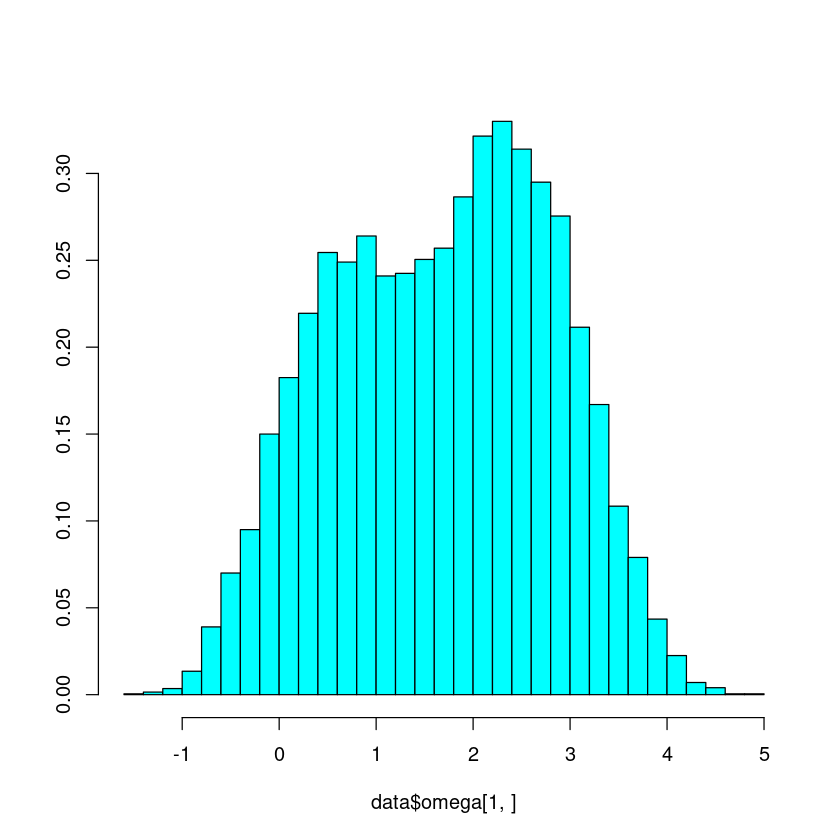

In [17]:
truehist(data$omega[1,])

In [19]:
pVars <- rpareto(10000, alpha=3+1e-06)


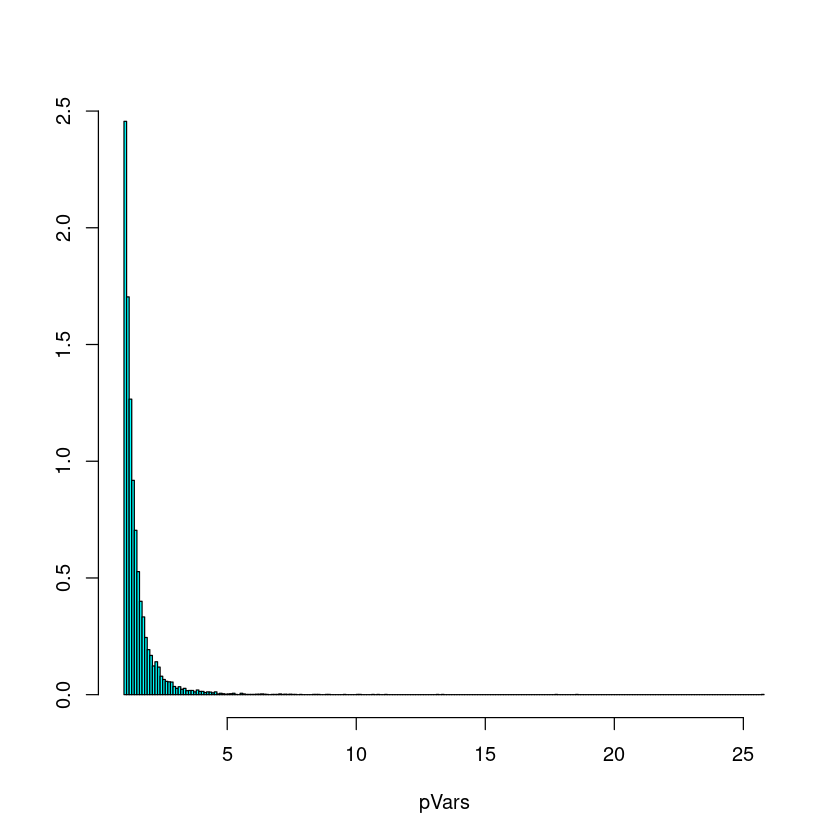

In [20]:
truehist(pVars)

# Scenarios Where we can show Improvement

- Gamma: shape=1, scale-4, SNR=3, top 10%

- Mixture Norm: centers at -5 and 1, standard deviations of 1 and 2, SNR= 1, all

# Scenarios to do (Choose Three)

- A gamma scenario, with the above parameters
- A Gaussian case, mean=0, sd=1
- A Gaussian Mixture case, with the above parameters